In [58]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import torch
import resampy
import librosa

from torch.autograd import backward
from kymatio.torch import TimeFrequencyScattering1D
from IPython.display import Audio
from librosa.display import specshow

SAMPLE_RATE = 44100

In [59]:

x, sr = librosa.load("/homes/cv300/Documents/jtfs-gpu/wav/spiegel.wav", sr=SAMPLE_RATE)
N = 145530
jtfs = TimeFrequencyScattering1D(
    J = 13, 
    shape = (N, ), 
    Q = 12, 
    J_fr=6,
    T=2**13,
    max_pad_factor=1,
    max_pad_factor_fr=1,
    average_fr = False,
).cuda()

In [61]:
import time

def reconstruct(x, 
                lr = 10, 
                n_iter = 200, 
                bold_driver_accelerator = 1.1, 
                bold_driver_brake = 0.55):
    start = time.time()

    err_history = []

    torch.manual_seed(0)
    noise = torch.randn((N,), requires_grad=True)
    S_noise = jtfs(noise.cuda())

    target = torch.from_numpy(x)
    S_target = jtfs(target.cuda())

    for i in range(n_iter):
        err = torch.norm(S_noise - S_target)

        if i % 10 == 0:
            print('Iteration %3d, loss %.2f' % (i, err.cpu().detach().numpy()))
            plot_cqt(noise.clone().cpu().detach().numpy(), it=i)

        err_history.append(err)
        err.backward() # backward pass

        # gradient descent
        delta_y = noise.grad
        with torch.no_grad():
            noise_new = noise - lr * delta_y
        noise_new.requires_grad = True       

        if err_history[i] > err_history[i - 1]:
            lr *= bold_driver_brake
        else:
            lr *= bold_driver_accelerator
            noise = noise_new

        S_noise = jtfs(noise) # forward pass

    end = time.time()
    print(end-start)
    return target, noise

def plot_cqt(x, it, out_dir="cqt_img"):
    C = np.abs(librosa.cqt(x, sr=SAMPLE_RATE))

    plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 2)
    specshow(librosa.amplitude_to_db(C, ref=np.max), 
             sr=SAMPLE_RATE, x_axis="time", y_axis="cqt_note")
    plt.xlabel("Time (s)")
    plt.title(f"Constant-Q power spectrum: iteration {it}")
    plt.savefig(f"cqt_img/{it}.png", bbox_inches='tight')


Iteration   0, loss 456.27
Iteration  10, loss 234.16
Iteration  20, loss 43.46
Iteration  30, loss 8.55
Iteration  40, loss 2.31
Iteration  50, loss 1.98
Iteration  60, loss 1.81
Iteration  70, loss 1.70
Iteration  80, loss 1.77
Iteration  90, loss 1.55
Iteration 100, loss 1.49
Iteration 110, loss 1.45
Iteration 120, loss 1.44
Iteration 130, loss 1.37
Iteration 140, loss 1.34
Iteration 150, loss 1.31
Iteration 160, loss 1.29
Iteration 170, loss 1.26
Iteration 180, loss 1.24
Iteration 190, loss 1.23
212.62917184829712


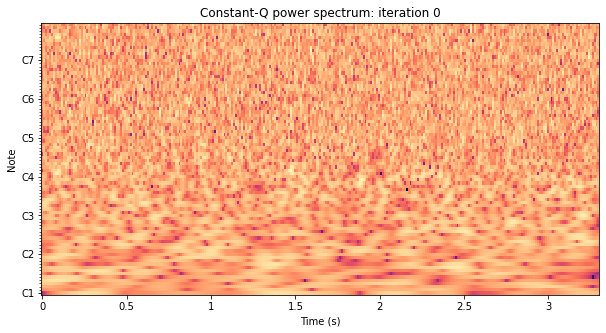

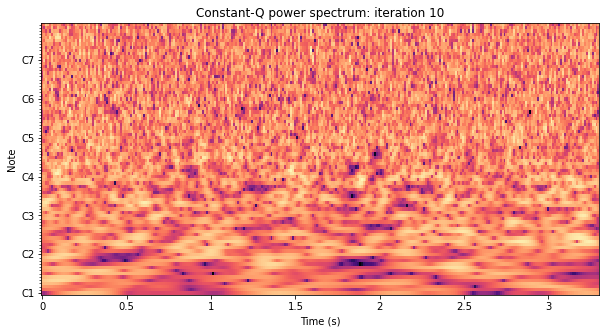

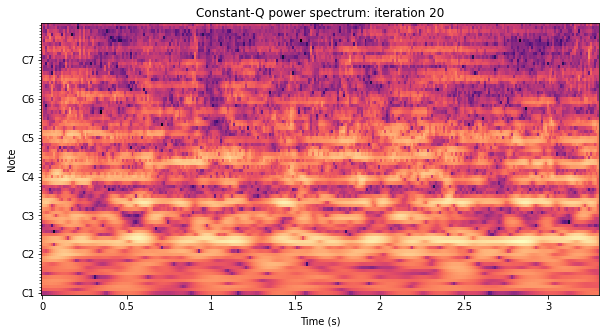

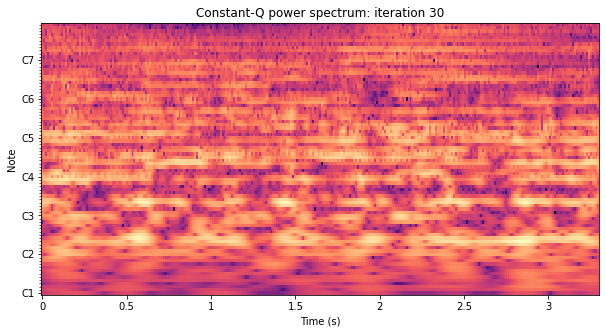

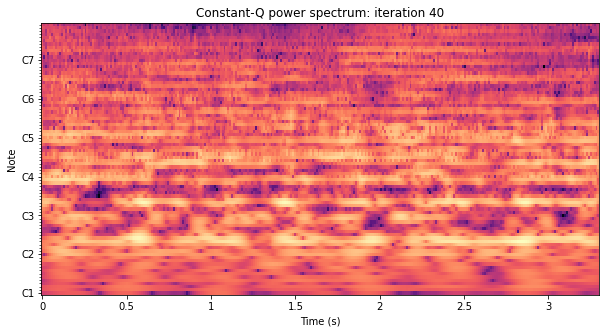

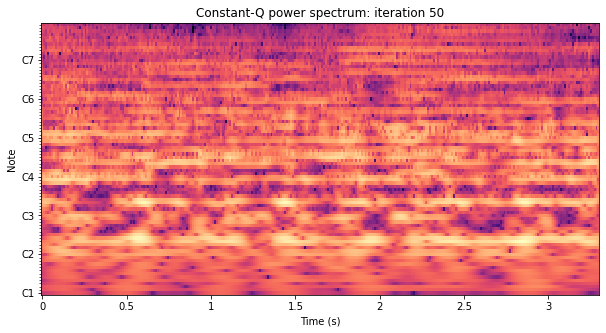

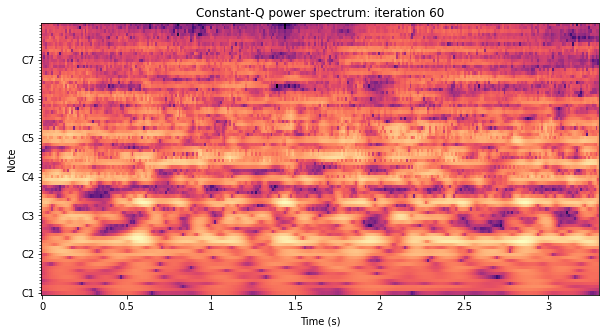

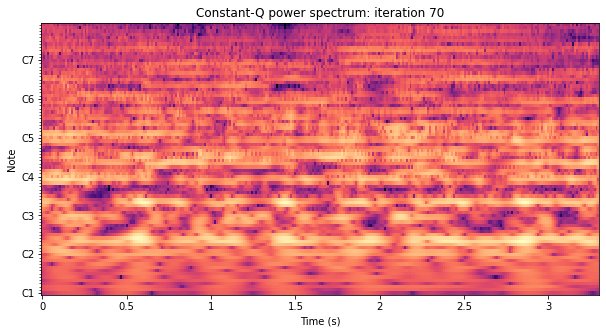

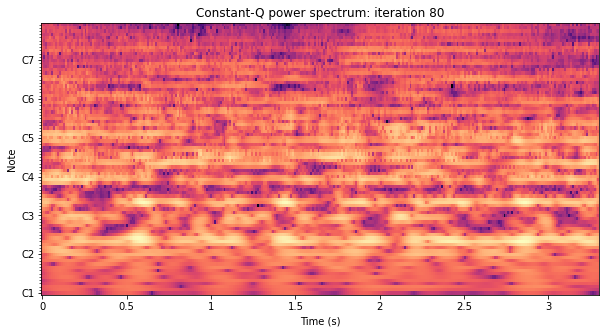

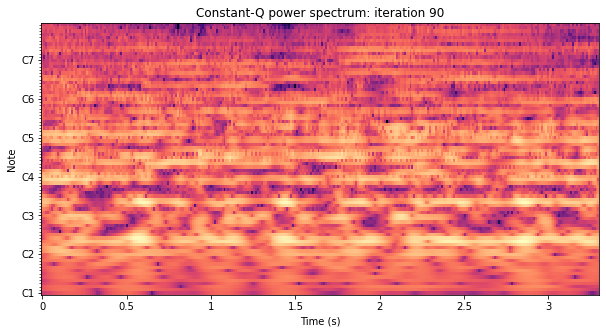

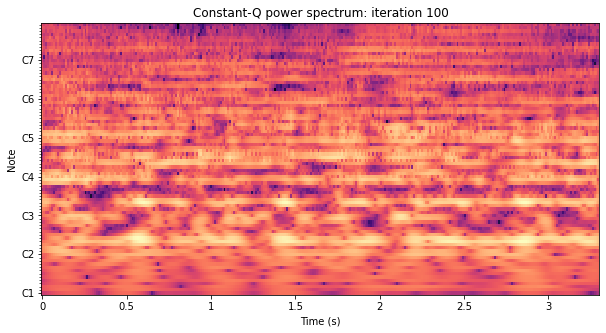

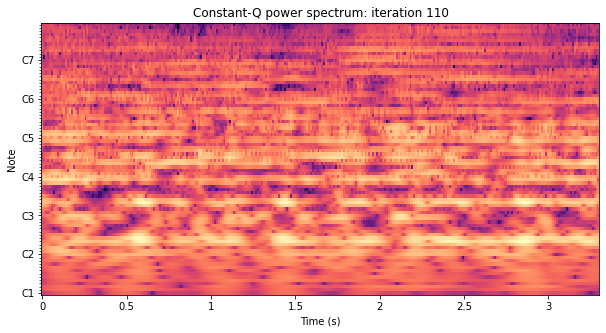

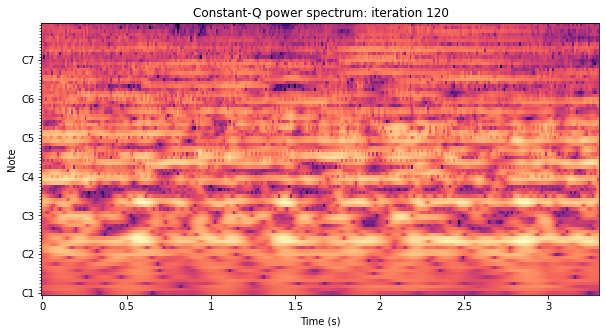

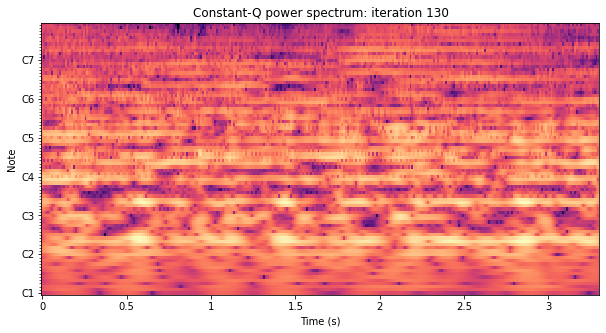

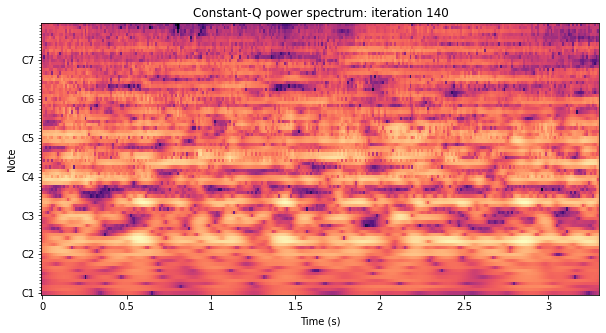

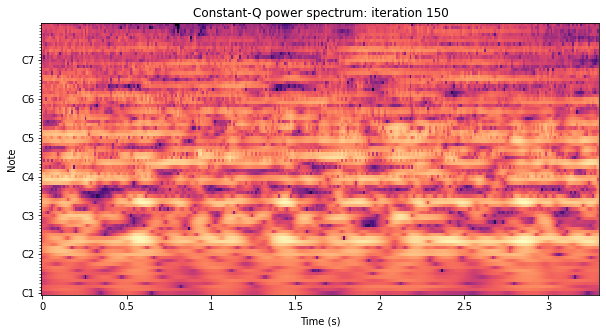

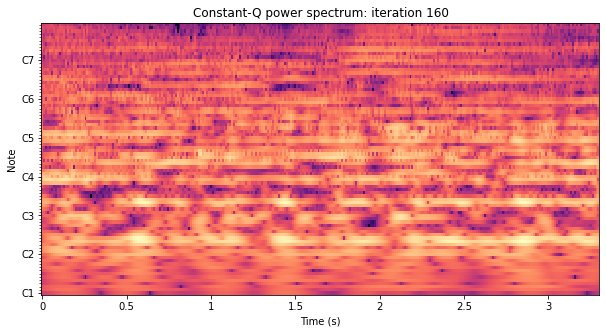

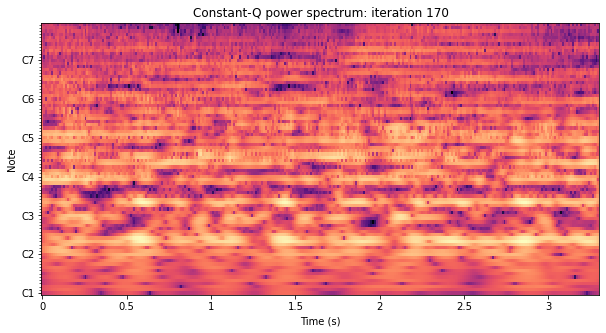

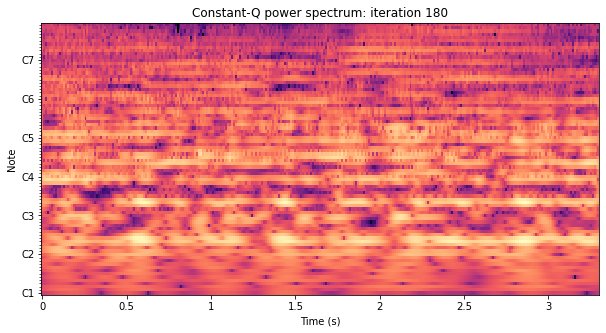

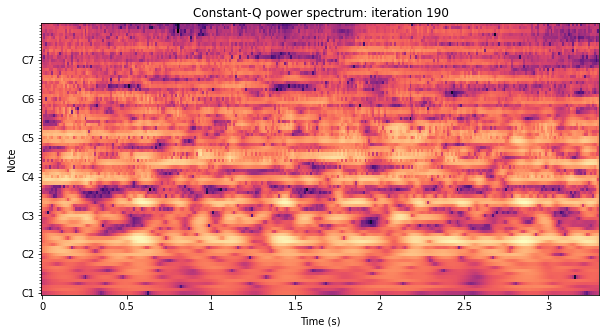

In [62]:

Audio(x, rate=sr, autoplay=True)

target, recon = reconstruct(x[:N])
# plot_spectrograms(target, recon)

In [64]:
y = recon.cpu().detach().numpy()
Audio(y, rate=sr, autoplay=True)
# Audio(x[:N], rate=sr, autoplay=True)
# Audio(torch.randn((N,)).numpy(), rate=sr, autoplay=True)

In [67]:
import imageio
frames = [] 

for i in range(0, 200, 10):
    img = imageio.imread(f"cqt_img/{i}.png")
    frames.append(img)

imageio.mimsave("cqt_img/0_iterations.gif", frames, fps=5)